In [15]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

# 一、数据准备

## 1.1 读取日度行情表

表内字段就是 Backtrader 默认情况下要求输入的 7 个字段： 'datetime' 、'open'、'high'、'low'、'close'、'volume'、'openinterest'，外加一个 'sec_code' 股票代码字段。

In [16]:
import pandas as pd
from datas import *

year = 2019
list_assets, df_assets = get_hs300_stocks(f'{year}-01-01')
df_org= get_all_date_data(f'{year}-01-01', f'{year+1}-01-01', list_assets)
df1 = df_org.rename(columns={
        "date": "datetime", 
        "asset": "sec_code"})
df1["openinterest"] = 0
daily_price=df1[['sec_code','datetime', "open", "close", "high", "low", "volume", 'openinterest']]
daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])
daily_price

login success!
login respond error_code:0
login respond  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
logout success!
300


<ipython-input-16-85d5e85e958d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])


,sec_code,datetime,open,close,high,low,volume,openinterest
0,600000,2019-01-02,9.74,9.70,9.79,9.58,237628,0
1,600000,2019-01-03,9.70,9.81,9.82,9.66,186543,0
2,600000,2019-01-04,9.73,9.96,10.00,9.70,271728,0
3,600000,2019-01-07,10.09,9.98,10.09,9.92,235974,0
4,600000,2019-01-08,10.03,9.96,10.03,9.91,151049,0
...,...,...,...,...,...,...,...,...
72881,300433,2019-12-25,14.20,14.19,14.38,14.09,353685,0
72882,300433,2019-12-26,14.19,14.11,14.36,13.96,383715,0
72883,300433,2019-12-27,14.13,13.64,14.38,13.64,523975,0
72884,300433,2019-12-30,13.52,13.79,13.99,13.12,484200,0


In [17]:
# 以 datetime 为 index，类型为 datetime 或 date 类型，Datafeeds 默认情况下是将 index 匹配给 datetime 字段；
daily_price = daily_price.set_index(['datetime'])
daily_price

,sec_code,open,close,high,low,volume,openinterest
datetime,,,,,,,
2019-01-02,600000,9.74,9.70,9.79,9.58,237628,0
2019-01-03,600000,9.70,9.81,9.82,9.66,186543,0
2019-01-04,600000,9.73,9.96,10.00,9.70,271728,0
2019-01-07,600000,10.09,9.98,10.09,9.92,235974,0
2019-01-08,600000,10.03,9.96,10.03,9.91,151049,0
...,...,...,...,...,...,...,...
2019-12-25,300433,14.20,14.19,14.38,14.09,353685,0
2019-12-26,300433,14.19,14.11,14.36,13.96,383715,0
2019-12-27,300433,14.13,13.64,14.38,13.64,523975,0


## 1.2 生成调仓信息表

表内数据说明：

+ trade_date： 调仓期（每月最后一个交易日）;

+ sec_code：持仓成分股；

+ weight：持仓权重。

In [18]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet

df_2 = df_org[['date', 'asset', "close"]]
df_2['date'] = pd.to_datetime(df_2['date'])
# print(df_all)

close = df_2.pivot(index='date', columns='asset', values='close')

alpha_num = 83
alpha_name = 'Alphas101'

# 读取已经计算好的因子
alpha = pd.read_csv('alphas/{}/{}/alpha{:03d}.csv'.format(alpha_name, year, alpha_num))

# 筛选出今年的数据，需与股票收盘日期区间一致
alpha = alpha[(alpha['date'] >= f'{year}-01-01') & (alpha['date'] <= f'{year+1}-01-01')]

# 因子矩阵转换为一维数据(alphalens需要的格式)
alpha = alpha.melt(id_vars=['date'], var_name='asset', value_name='factor' )

# date列转为日期格式
alpha['date'] = pd.to_datetime(alpha['date'])
alpha = alpha[['date', 'asset', 'factor']]

# 设置二级索引
alpha = alpha.set_index(['date', 'asset'], drop=True)
alpha.sort_index(inplace=True)


ret = get_clean_factor_and_forward_returns(alpha, close,quantiles=5)
ret = ret.reset_index()
ret = ret[ret['factor_quantile'] == 5]
ret = ret[['date','asset']]
ret['weight'] = 1/60
trade_info = ret.rename(columns={
        "date": "trade_date", 
        "asset": "sec_code"})
trade_info

<ipython-input-18-3029e40aae47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['date'] = pd.to_datetime(df_2['date'])


Dropped 5.0% entries from factor data: 5.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,trade_date,sec_code,weight
2,2019-01-02,000063,0.016667
7,2019-01-02,000333,0.016667
15,2019-01-02,000503,0.016667
18,2019-01-02,000568,0.016667
22,2019-01-02,000651,0.016667
...,...,...,...
69545,2019-12-17,601881,0.016667
69549,2019-12-17,601901,0.016667
69565,2019-12-17,603799,0.016667
69567,2019-12-17,603858,0.016667


# 二、 选股回测

 选股策略：定期按持仓权重调仓 。

In [20]:
# 回测策略
class TestStrategy(bt.Strategy):
    params = (
        ('buy_stocks', None), # 传入各个调仓日的股票列表和相应的权重
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
         # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.p.buy_stocks['trade_date'].unique()).tolist()
        self.buy_stock = self.p.buy_stocks # 保留调仓信息
        self.order_list = []  # 记录以往订单，在调仓日要全部取消未成交的订单
        self.buy_stocks_pre = [] # 记录上一期持仓
    
    def next(self):
        # 获取当前的回测时间点
        dt = self.datas[0].datetime.date(0)
        # 打印当前时刻的总资产
        self.log('当前总资产 %.2f' %(self.broker.getvalue()))
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print("--------------{} 为调仓日----------".format(dt))
            #取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                print("--------------- 撤销未完成的订单 -----------------")
                for od in self.order_list:
                    # 如果订单未完成，则撤销订单
                    self.cancel(od) 
                 #重置订单列表
                self.order_list = [] 
                
            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表
            
            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if len(sell_stock) > 0:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单

            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)
                
            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    #订单日志    
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已被处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.ref,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref,
                         order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))

In [21]:
# 实例化大脑
cerebro_ = bt.Cerebro() 

# 按股票代码，依次循环传入数据
for stock in daily_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique())
    df = daily_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    datafeed = bt.feeds.PandasData(dataname=data_, fromdate=datetime.datetime(2019,1,2), todate=datetime.datetime(2021,1,28))
    cerebro_.adddata(datafeed, name=stock)
    print(f"{stock} Done !") 

600000 Done !
600004 Done !
600009 Done !
600010 Done !
600011 Done !
600015 Done !
600016 Done !
600018 Done !
600019 Done !
600023 Done !
600025 Done !
600027 Done !
600028 Done !
600029 Done !
600030 Done !
600031 Done !
600036 Done !
600038 Done !
600048 Done !
600050 Done !
600061 Done !
600066 Done !
600068 Done !
600085 Done !
600089 Done !
600100 Done !
600104 Done !
600109 Done !
600111 Done !
600115 Done !
600118 Done !
600153 Done !
600157 Done !
600170 Done !
600176 Done !
600177 Done !
600188 Done !
600196 Done !
600208 Done !
600219 Done !
600221 Done !
600233 Done !
600271 Done !
600276 Done !
600297 Done !
600309 Done !
600332 Done !
600339 Done !
600340 Done !
600346 Done !
600352 Done !
600362 Done !
600369 Done !
600372 Done !
600383 Done !
600390 Done !
600398 Done !
600406 Done !
600415 Done !
600436 Done !
600438 Done !
600482 Done !
600487 Done !
600489 Done !
600498 Done !
600516 Done !
600518 Done !
600519 Done !
600522 Done !
600535 Done !
600547 Done !
600549

# 三、添加分析器

In [26]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000.0) 
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro.run()

2019-01-02, 当前总资产 100000.00
--------------2019-01-02 为调仓日----------
long_list ['000063', '000333', '000503', '000568', '000651', '000661', '000858', '000963', '001979', '002001', '002007', '002008', '002024', '002027', '002044', '002081', '002179', '002202', '002230', '002236', '002271', '002304', '002310', '002415', '002450', '002456', '002460', '002466', '002475', '002572', '002594', '300003', '300015', '300059', '300070', '300122', '300136', '300144', '300408', '300433', '600104', '600176', '600196', '600271', '600276', '600332', '600519', '600535', '600570', '600809', '600867', '600887', '601012', '601318', '601336', '601878', '601992', '603259', '603799', '603986']
sell_stock []
-----------买入此次调仓期的股票--------------
2019-01-03, BUY EXECUTED, ref:48415, Price: 19.59, Cost: 1567.20, Comm 0.00, Size: 80.00, Stock: 000063
2019-01-03, BUY EXECUTED, ref:48416, Price: 36.26, Cost: 1559.18, Comm 0.00, Size: 43.00, Stock: 000333
2019-01-03, BUY EXECUTED, ref:48417, Price: 15.57, Cost: 1588.1

In [27]:
strat = result[0]
print("--------------- AnnualReturn -----------------")
print(strat.analyzers._AnnualReturn.get_analysis())
print("--------------- DrawDown -----------------")
print(strat.analyzers._DrawDown.get_analysis())
print("--------------- Returns -----------------")
print(strat.analyzers._Returns.get_analysis())
print("--------------- SharpeRatio -----------------")
print(strat.analyzers._SharpeRatio.get_analysis())
print("--------------- SharpeRatio_A -----------------")
print(strat.analyzers._SharpeRatio_A.get_analysis())

--------------- AnnualReturn -----------------
OrderedDict([(2019, 0.5193134999999969)])
--------------- DrawDown -----------------
AutoOrderedDict([('len', 0), ('drawdown', 0.0), ('moneydown', 0.0), ('max', AutoOrderedDict([('len', 178), ('drawdown', 15.254067850427479), ('moneydown', 22598.44999999991)]))])
--------------- Returns -----------------
OrderedDict([('rtot', 0.418258588099137), ('ravg', 0.0017141745413899057), ('rnorm', 0.5402919623997569), ('rnorm100', 54.02919623997568)])
--------------- SharpeRatio -----------------
OrderedDict([('sharperatio', 2.0046179518213916)])
--------------- SharpeRatio_A -----------------
OrderedDict([('sharperatio', None)])


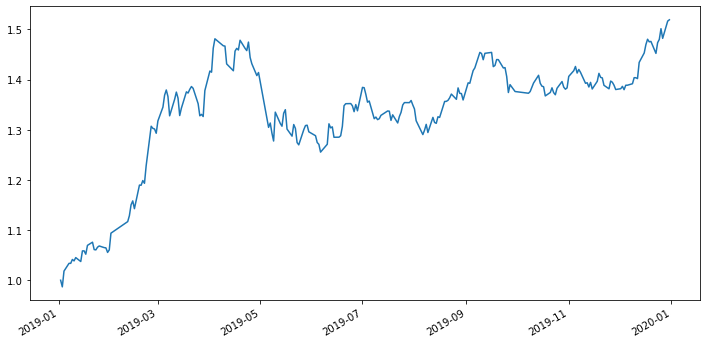

In [28]:
# 绘制累计收益率
ret = pd.Series(strat.analyzers._TimeReturn.get_analysis())
(ret + 1).cumprod().plot(figsize=(12,6))

In [29]:
def get_my_analyzer(result):
    analyzer = {}

    # 提取年化收益
    analyzer['年化收益率'] = result.analyzers._Returns.get_analysis()['rnorm']
    analyzer['年化收益率（%）'] = result.analyzers._Returns.get_analysis()['rnorm100']
    # 提取最大回撤
    analyzer['最大回撤（%）'] = result.analyzers._DrawDown.get_analysis()['max']['drawdown'] * (-1)
    # 提取夏普比率
    analyzer['夏普比率'] = result.analyzers._SharpeRatio.get_analysis()['sharperatio']
    
    return analyzer

ret = []
# for i in result:
ret.append(get_my_analyzer(result[0]))
    
pd.DataFrame(ret).sort_values(by='年化收益率', ascending=False)

,年化收益率,年化收益率（%）,最大回撤（%）,夏普比率
0,0.540292,54.029196,-15.254068,2.004618
